# Peak Integration $N_2O$ Example

A small showcase how to perform multiple peak integration with automated Deconvolution using the $N_2O$ Spectrum as an example

In [2]:
import numpy as np
import pandas as pd
from modules import spec_tools 

## Step 1: Plot Total Spectra

For this load in the data then use the respective plotting function.

In [3]:
spectrum = spec_tools.Spectrum.from_csv("shee2.csv",sep=";",comma=",")

print(spectrum.data.shape)

(57816, 4)


In [4]:
spectrum.plot_spectrum(title="Total Spectrum")

alt.Chart(...)

# Import Annotation

Given a VCI Calculation one can Import the Predictions given by the calculation by using the respective import method.

In [5]:
spectrum.import_vci_prediction("/home/lme/peak_int_python/ir_peak_int/446.out")

print(spectrum.annotations)

{'fundamentals': {'4^1': {'Symmetry': 'A1', 'E_abs': '4612.17', 'VCI_freq': '2231.58', 'IR_intensity': '566.76'}, '3^1': {'Symmetry': 'A1', 'E_abs': '3671.09', 'VCI_freq': '1290.50', 'IR_intensity': '108.01'}, '2^1': {'Symmetry': 'E1', 'E_abs': '2973.99', 'VCI_freq': '593.40', 'IR_intensity': '8.66'}, '1^1': {'Symmetry': 'E1', 'E_abs': '2973.99', 'VCI_freq': '593.40', 'IR_intensity': '8.66'}}, 'overtones': {'4^2': {'Symmetry': 'A1', 'E_abs': '6814.38', 'VCI_freq': '4433.80', 'IR_intensity': '1.32'}, '3^2': {'Symmetry': 'A1', 'E_abs': '4955.78', 'VCI_freq': '2575.19', 'IR_intensity': '14.54'}, '2^2': {'Symmetry': 'A1', 'E_abs': '3568.57', 'VCI_freq': '1187.98', 'IR_intensity': '0.00'}, '1^2': {'Symmetry': 'A1', 'E_abs': '3568.57', 'VCI_freq': '1187.98', 'IR_intensity': '0.00'}, '3^1': {'Symmetry': '4^1', 'E_abs': 'A1', 'VCI_freq': '5875.25', 'IR_intensity': '3494.66'}, '2^1': {'Symmetry': '3^1', 'E_abs': 'E1', 'VCI_freq': '4271.56', 'IR_intensity': '1890.97'}, '1^1': {'Symmetry': '2^1',

In [6]:
# plot the annotations

spectrum.plot_spectrum_with_vci_annotations(title="Total Spectrum with VCI Annotations",mode=1)

alt.LayerChart(...)

In [7]:
Spectrum_dev =spectrum.derivative_spectrum()

Spectrum_dev.plot_spectrum()

alt.Chart(...)

We now focus on the spectral region 2260 - 2160 $cm^{-1}$



In [8]:
chart, peaks = spectrum.plot_spectral_window_peak_picking(x_min=2160, x_max=2300,threshold=0.05)
chart

alt.LayerChart(...)

Next we split the spectrum two spectral windows so we consider 2215 - 2200 $cm^{-1}$ and 2195 - 2175 $cm^{-1}$

In [9]:
window1 = [2200, 2215]
window2 = [2175, 2195]

windows = [window1, window2]

spectrum1 = spectrum.split_spectral_window(window1)
spectrum2 = spectrum.split_spectral_window(window2)

spectrum.plot_multiple_spectral_windows(ls_of_windows=windows)

alt.VConcatChart(...)

In [10]:
grid, integrals = spectrum.integrate_multiple_spectral_windows(windows, title="Hello")

grid

alt.VConcatChart(...)

In [11]:
print(integrals)

print(integrals[0]/integrals[1])

[0.30028418050000644, 0.2981729529999906]
1.0070805466383663


# Baseline Fitting of both Windows

Now we apply Baseline Fitting to both the peaks inside the spectral window.

Concrete we use asls smoothing (Whittaker)

In [12]:
Baseline1 = spec_tools.Baseline(spectrum1)
Baseline2 = spec_tools.Baseline(spectrum2)

# Define Parameters:
# lambda, tol, max_iter

lam = 1e2
tol = 1e-6
max_iter = 30

lam2 = 1e2

fit1, params1 = Baseline1.fit_baseline_asls(lam=lam, tol=tol, max_iter=max_iter)

fit2, params2 = Baseline2.fit_baseline_asls(lam=lam2, tol=tol, max_iter=max_iter)

In [13]:
Baseline1.plot_baseline_and_spectrum(title="Baseline Peak 2215-2200")

alt.LayerChart(...)

In [14]:
Baseline2.plot_baseline_and_spectrum(title="Baseline Peak 2195-2175")

alt.LayerChart(...)

In [15]:
#substrtact baseline from spectrum

spectrum1_corr = Baseline1.substract_baseline()
spectrum2_corr = Baseline2.substract_baseline()

In [16]:
spectrum1_corr.plot_spectrum(title="Corrected Spectrum Peak 2215-2200")

alt.Chart(...)

In [17]:
spectrum2_corr.plot_spectrum(title="Corrected Spectrum Peak 2195-2175")

alt.Chart(...)

# Integration and Deconvolution

Next we integrate the spectrum, this can be done automatically by the following sequence of step:

1. Perform Peak-Picking
2. Initialize the Deconvolution Object
3. Fit Gaussian or other deconvoltion function and calculate the Integrals

In [18]:
spectrum1_corr.interactive_integration()

alt.LayerChart(...)

In [19]:
spectrum2_corr.interactive_integration()

alt.LayerChart(...)

In [20]:
# Perform Peak Picking on corrected spectrum

chart1, peaks1 = spectrum1_corr.plot_spectrum_peak_picking(threshold=0.003)
chart1

alt.LayerChart(...)

In [21]:
chart2, peaks2 = spectrum2_corr.plot_spectrum_peak_picking(threshold=0.003)
chart2

alt.LayerChart(...)

On this second chart we see that maybe the peak 3 is a little bit of we can simply exclude it from our Analysis by removing the respective peak from the list

In [22]:
peaks2 = np.delete(peaks2, 3)
print(peaks2)

[ 90 109 128]


In [23]:
# Now initialize the Deconvolution Object

Deconvolution1 = spec_tools.Deconvolution(spectrum1_corr, peaks1)
Deconvolution2 = spec_tools.Deconvolution(spectrum2_corr, peaks2)

# Deconvolution using a numerical approach in Fourier Space

Given an observed signal $o(x)$ we want a well-resolved version $s(x)$ from a known broadening function 


\begin{align}
o(x) = s(x)\cdot b(x) + n(x)
\end{align}

By using the deconvolution theorem:

\begin{align}
F\{o(x)\} = F\{ s(x)\}F\{ b(x)\} + F\{ n(x)\}
\end{align}

we can now write

\begin{align}
F\{s(x)\} = \frac{F \{ o(x)\}}{F \{ b(x)\}} - \frac{F \{ n(x) \}}{F \{ b(x)\}}
\end{align}


### Functions we need

**Mixed Gaussian Lorentian as our Deconvolving Function**

> Sadly i dont get this function to work

\begin{align}
b = \frac{2m \sqrt{\ln 2}}{\beta \sqrt{\pi}}\exp  \left( -4 \ln 2 (\frac{x_n - M}{\beta})^2 \right) + \frac{2(1-m)}{\beta \pi (1+4(\frac{x_n - M}{\beta})^2)}
\end{align}

where:

+ $m=1$ gives pure Gaussian, $m=0$ gives pure Lorentzian
+ $M = mean(x_n) + 0.5$ (Sampling Interval)
+ $\beta$ is full with at half maximum

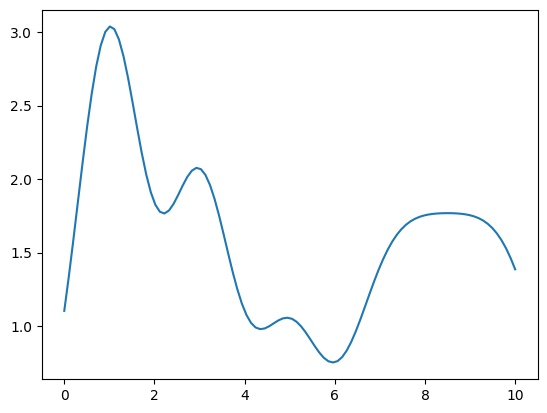

In [24]:
#make test data
import numpy as np
import matplotlib.pyplot as plot

x = np.linspace(0, 10, 100)

# make sum of 7 peaks as test function

y = 3 * np.exp(-(x - 1) ** 2) + 2 * np.exp(-(x - 3) ** 2) + 1 * np.exp(-(x - 5) ** 2) + 1 * np.exp(-(x - 7) ** 2) + 1 * np.exp(-(x - 8) ** 2) + 1 * np.exp(-(x - 9) ** 2) + 1 * np.exp(-(x - 10) ** 2)

plot.plot(x, y)

In [25]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(y, height=1)

print(peaks)

data = np.column_stack((x, y))

spectrum_test = spec_tools.Spectrum(name="Test",data=data)

Deconvolution_test = spec_tools.Deconvolution(spectrum_test, peaks)

# Fit the peaks

popt1 = Deconvolution_test.fit_gaussian(peaks[0])
popt2 = Deconvolution_test.fit_gaussian(peaks[1],broadness=5)
popt3 = Deconvolution_test.fit_gaussian(peaks[2],broadness=2)
popt4 = Deconvolution_test.fit_gaussian(peaks[3],broadness=15)

# Plot the results

plt.plot(x, y)
plt.plot(x, spec_tools.Deconvolution.gaussian(x, *popt1))
plt.plot(x, spec_tools.Deconvolution.gaussian(x, *popt2))
plt.plot(x, spec_tools.Deconvolution.gaussian(x, *popt3))
plt.plot(x, spec_tools.Deconvolution.gaussian(x, *popt4))
plt.show()

[10 29 49 84]


NameError: name 'plt' is not defined

In [ ]:
# Calculate fwhm

fwhm1 = 2*np.sqrt(2*np.log(2))*popt1[2]
fwhm2 = 2*np.sqrt(2*np.log(2))*popt2[2]
fwhm3 = 2*np.sqrt(2*np.log(2))*popt3[2]
fwhm4 = 2*np.sqrt(2*np.log(2))*popt4[2]

print(fwhm1)
print(fwhm2)
print(fwhm3)
print(fwhm4)

0.9745737058547309
0.8708541473667974
0.6393722591981417
5.472035999945754


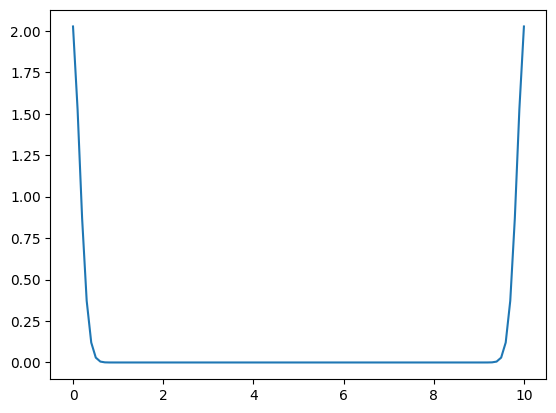

In [ ]:
# make deconvolution function

deconv_func = spec_tools.Deconvolution.deconvolution_function(mode="Gaussian",FWHM=0.70*fwhm3)

y_deconv_range = deconv_func(x)

plot.plot(x, y_deconv_range)
plot.show()

/tmp/ipykernel_4061509/1325500824.py:19: RuntimeWarning: divide by zero encountered in divide
  devonv_func = (y_fft/y_deconv)*window_function(len(y))
/tmp/ipykernel_4061509/1325500824.py:19: RuntimeWarning: invalid value encountered in divide
  devonv_func = (y_fft/y_deconv)*window_function(len(y))
/tmp/ipykernel_4061509/1325500824.py:19: RuntimeWarning: invalid value encountered in multiply
  devonv_func = (y_fft/y_deconv)*window_function(len(y))
/tmp/ipykernel_4061509/1325500824.py:27: RuntimeWarning: invalid value encountered in divide
  y_deconvolved = y_deconvolved * np.sum(y)/np.sum(y_deconvolved)
/home/lme/.conda/envs/molecular_m/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


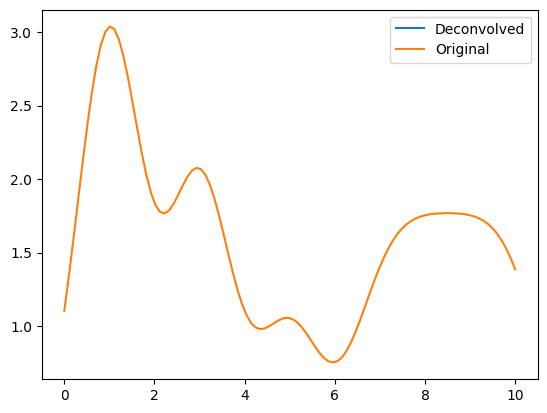

In [ ]:
from scipy.fft import fft, ifft

y_fft = fft(y)
y_deconv = fft(y_deconv_range)

# Make window function

def window_function(N):
    k = np.arange(0,N)
    Z = np.mean(k) + 0.5
    r=9
    p = 2
    W =np.exp(-(np.abs(k-Z)/r)**p)

    W_shifted = np.roll(W, N//2)

    return W_shifted

devonv_func = (y_fft/y_deconv)*window_function(len(y))

# Perform inverse fft

y_deconvolved = ifft(devonv_func)

# Rescale the deconvolved function

y_deconvolved = y_deconvolved * np.sum(y)/np.sum(y_deconvolved)



plot.plot(x, y_deconvolved,label="Deconvolved")
plot.plot(x, y,label="Original")
plot.legend()
plot.show()




### Step 1

Starting from analytical signal of N points, fit the raw data to estimate peak with


In [ ]:
popt1 = Deconvolution1.fit_gaussian(peaks1[0])
popt2 = Deconvolution1.fit_gaussian(peaks1[1])
popt3 = Deconvolution1.fit_gaussian(peaks1[2])

# Second parameter is sigmga
print(popt1)
print(popt2)
print(popt3)

# Calculate FWHM = 2 * sqrt(2 * ln(2)) * sigma

fwhm1 = 2 * np.sqrt(2 * np.log(2)) * popt1[2]
fwhm2 = 2 * np.sqrt(2 * np.log(2)) * popt2[2]
fwhm3 = 2 * np.sqrt(2 * np.log(2)) * popt3[2]

print(fwhm1)
print(fwhm2)
print(fwhm3)


NameError: name 'Deconvolution1' is not defined

### Step 2

Generate a deconvolving function of N points form the chosen peak model (gaussian, lorentzian ...) whose FWMH is 70-80 % of the narrowest peaks as a starting guess.


<function Deconvolution.deconvolution_function.<locals>.gaussian at 0x7f50c892d940>


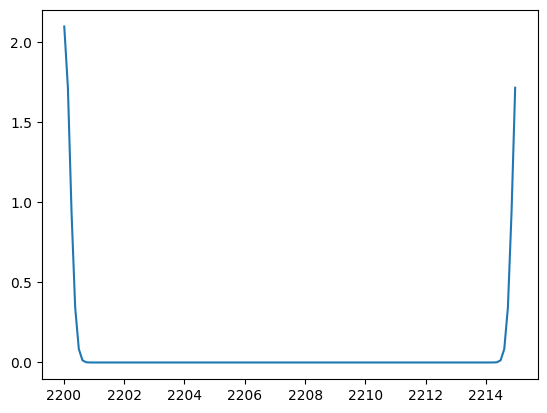

In [ ]:
import matplotlib.pyplot as plt

Deconv_Funct = spec_tools.Deconvolution.deconvolution_function(mode="Gaussian",FWHM=0.7*fwhm3)
print(Deconv_Funct)

y_deconv_spectral_range = Deconv_Funct(Deconvolution1.spectrum.data[:,0])

plt.plot(Deconvolution1.spectrum.data[:,0], y_deconv_spectral_range, label="Deconvolution Function")
plt.show()

### Step 3

Obtain FFTs of the raw signal and the deconvolution function

In [ ]:
from scipy.fft import fft,ifft

# Obtain FFT of Signal

y_signal = Deconvolution1.spectrum.data[:,1]
y_signal_fft = fft(y_signal)

# Obtain FFT of Deconvolution Function
y_deconv_spectral_range_fft = fft(y_deconv_spectral_range)



### Step 4

Implement Equation (5) form the manuscript

\begin{align}
[s_n] = IDFF \left( \frac{O[k]}{(B[k]+D[k])} \times W[k] \right)
\end{align}

Where:

+ $s_n$ is the signal
+ $O[k]$ is fourier transformed original signal
+ $B[k]$ is convolution function

In [ ]:
def window_function(N):
    k = np.arange(0,N)
    print(k)
    Z = np.mean(k) + 0.5
    r=10
    p = 2
    W =np.exp(-(np.abs(k-Z)/r)**p)

    W_shifted = np.roll(W, N//2)

    return W_shifted

window_function(10)

[0 1 2 3 4 5 6 7 8 9]


array([1.        , 0.99004983, 0.96078944, 0.91393119, 0.85214379,
       0.77880078, 0.85214379, 0.91393119, 0.96078944, 0.99004983])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]


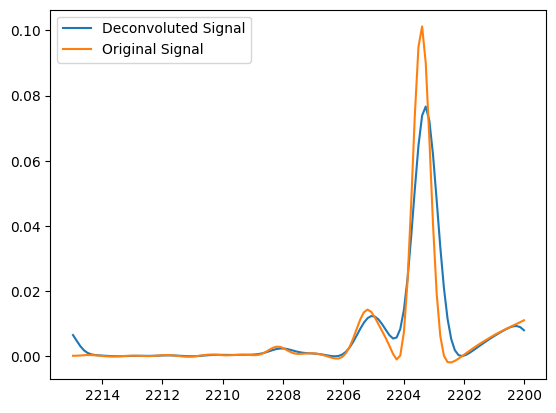

In [ ]:

deconv = (y_signal_fft/y_deconv_spectral_range_fft)*window_function(len(y_signal))

#correct_area
deconv = deconv * np.sum(y_signal)/np.sum(deconv)

deconv_signal = ifft(deconv)

plt.plot(Deconvolution1.spectrum.data[:,0], deconv_signal, label="Deconvoluted Signal")
plt.plot(Deconvolution1.spectrum.data[:,0], y_signal, label="Original Signal")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

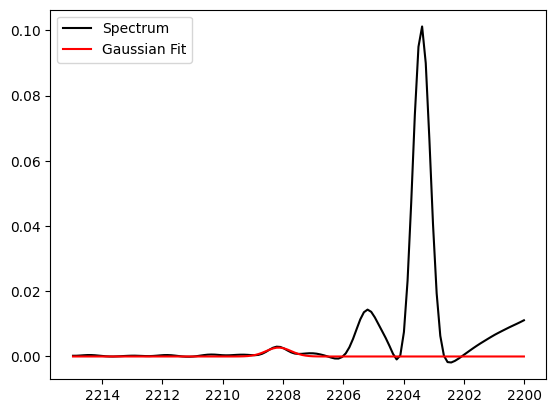

In [ ]:
Deconvolution1.plot_gaussian_fit(peaks1[0])

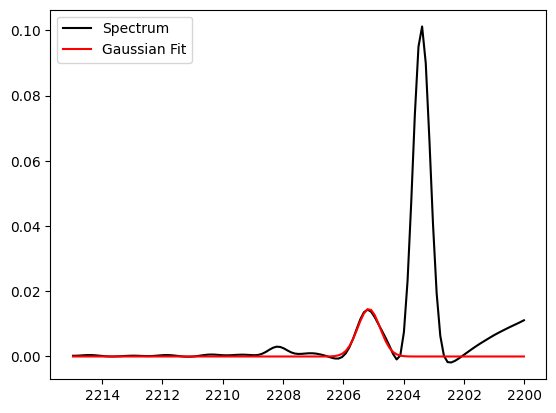

In [ ]:
Deconvolution1.plot_gaussian_fit(peaks1[1])

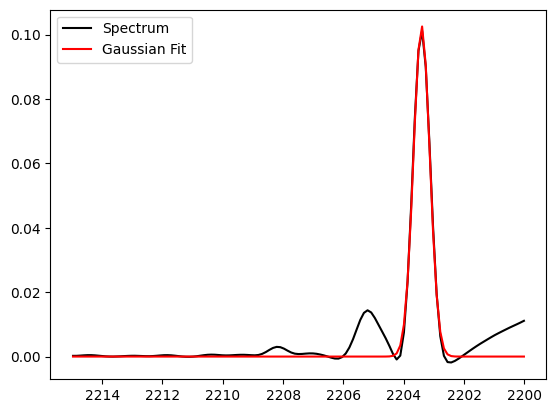

In [ ]:
Deconvolution1.plot_gaussian_fit(peaks1[2])

In [ ]:
Deconvolution1.fit_multiple_gaussians_and_plot(broadness=3)

alt.LayerChart(...)

In [ ]:
Deconvolution2.fit_multiple_gaussians_and_plot(broadness=3)

alt.LayerChart(...)

In [ ]:
# Name the Spectra

Deconvolution1.spectrum.name = "[2215-2200]"
Deconvolution2.spectrum.name = "[2195-2175]"

In [ ]:
# Finally we can calculate the Area of these functions

integral1, annotations1 = Deconvolution1.calculate_integral_of_fits()
integral2, annotations2 = Deconvolution2.calculate_integral_of_fits()


print(sum(integral1))
print(sum(integral2))

total_annotations = annotations1 + annotations2




spec_tools.Deconvolution.heatmap_integrals(total_annotations)


0.08685438562965389
0.08160836867431831


alt.LayerChart(...)

In [ ]:
# Plot the Data in A Histogram

spec_tools.Deconvolution.barplot_integrals(annotations1)

alt.LayerChart(...)

In [ ]:
spec_tools.Deconvolution.barplot_integrals(annotations2)

alt.LayerChart(...)

## Use different Deconvolution



In [ ]:
Deconvolution1.plot_poly_gaussian_fit(Deconvolution1.peaks[2], broadness=3,m=1.5)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [ ]:
m =[1,1,1]

Deconvolution1.fit_multiple_poly_gaussians_and_plot(broadness=3,ls_of_m=m)



alt.LayerChart(...)

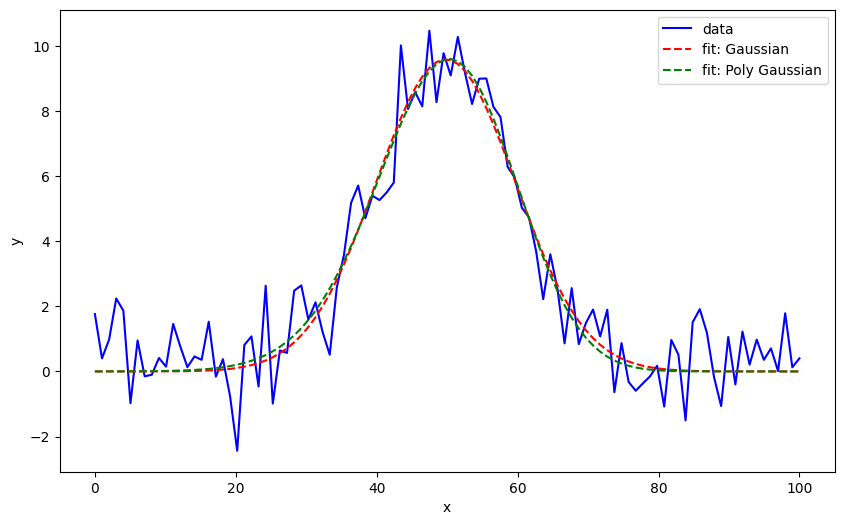

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

# Define Gaussian and Polynomially Modified Gaussian functions
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def poly_gaussian(x, a, x0, sigma, m):
    return a * np.exp(-0.5 * ((x-x0)**2/((sigma + m*(x-x0))**2)))

# Generate random data
np.random.seed(0)
x = np.linspace(0, 100, 100)
y = gaussian(x, 10, 50, 10) + np.random.normal(0, 1, x.size)

# Fit Gaussian
popt_gaussian, _ = curve_fit(gaussian, x, y, p0=[10, 50, 10])

# Fit Polynomially Modified Gaussian
popt_poly_gaussian, _ = curve_fit(poly_gaussian, x, y, p0=[10, 50, 10, 3])

# Plot the data and the fits
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', label='data')
plt.plot(x, gaussian(x, *popt_gaussian), 'r--', label='fit: Gaussian')
plt.plot(x, poly_gaussian(x, *popt_poly_gaussian), 'g--', label='fit: Poly Gaussian')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()